<a href="https://colab.research.google.com/github/JALVARADORUIZ/TFM_UB/blob/main/version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.svm import SVC

from tqdm import tqdm
tqdm.pandas()


dim = 100

In [3]:
data = '/content/drive/MyDrive/TFM_Máster BDDS/datawine/df_img_processed2.csv'
df = pd.read_csv(data)

In [4]:
df.columns[0:15]

Index(['winery', 'product', 'region', 'country_code', 'rating', 'variety',
       'price_usd', 'image', 'continente', 'country_code_clean', 'price_cat',
       'rating_cat', 'quality', 'color', 'image_clean'],
      dtype='object')

In [4]:
def getFeatures(files):
    images = []
    path = "/content/drive/MyDrive/TFM_Máster BDDS/datawine/vintage-images/"
    for f in enumerate(files):
        #print(f[1])
        image_path = path + f[1]
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (dim, dim))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        images.append(image)
    return images

X = getFeatures(df['image_clean'])

In [5]:
X = np.array(X)
X.shape

(9878, 100, 100, 3)

In [6]:
with open('/content/drive/MyDrive/TFM_Máster BDDS/100_features.npy', 'wb') as f:
    np.save(f, X)

In [ ]:
with open('/content/drive/MyDrive/TFM_Máster BDDS/100_features.npy', 'rb') as f:
    X= np.load(f)

In [7]:
df_variety = df['variety'].value_counts().rename_axis('variety').to_frame('counts')
df_variety_selected = df_variety[:15]
list_variety = list(df_variety_selected.index)

def transform_variety(variety, list_variety):
  if variety in list_variety:
    return variety
  else:
    return "other"

df['variety'] = df.progress_apply(lambda x:transform_variety(x.variety,list_variety), axis=1)

le = LabelEncoder()
variedad = le.fit_transform(df['variety'])
y = np.array(variedad)

100%|██████████| 9878/9878 [00:03<00:00, 3079.67it/s]


In [8]:
y.shape

(9878,)

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [11]:
#Scale Data Images
scaler = StandardScaler()
#X_train = scaler.fit_transform([i.flatten() for i in X_train])
#X_test = scaler.fit_transform([i.flatten() for i in X_test])
X_scaled = scaler.fit_transform([i.flatten() for i in X])

Busqueda de n_components PCA

suma: 0.8235646572548613


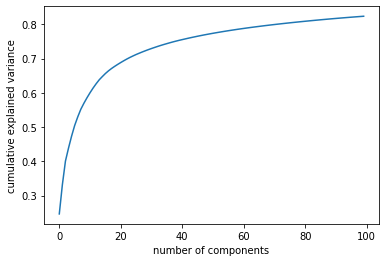

In [12]:
#Instanciamos objeto PCA y aplicamos
pca=PCA(n_components=100) 
pca.fit(X_scaled) # obtener los componentes principales
X_pca=pca.transform(X_scaled) # convertimos nuestros datos con las nuevas dimensiones de PCA
 
#print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
#print(expl)
print('suma:',sum(expl[0:100]))

 
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

suma: 0.8667198349859163


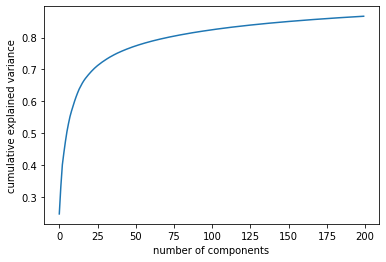

In [13]:
#Instanciamos objeto PCA y aplicamos
pca=PCA(n_components=200) 
pca.fit(X_scaled) # obtener los componentes principales
X_pca=pca.transform(X_scaled) # convertimos nuestros datos con las nuevas dimensiones de PCA
 
#print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
#print(expl)
print('suma:',sum(expl[0:200]))

 
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state=32)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6914, 200), (2964, 200), (6914,), (2964,))

In [17]:
param_range=[0.001,0.01,0.1,1,10]
param_grid =[
              {'kernel':['rbf'],
               'C':param_range,
               'gamma':param_range
              }
             ]

In [19]:
from sklearn.model_selection import GridSearchCV, cross_val_score

gs_svc = GridSearchCV(SVC(),
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=3,
                      verbose=2,
                      n_jobs=-1)

In [20]:
model_svc = gs_svc.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [21]:
model_svc.best_estimator_

SVC(C=10, gamma=0.001)

In [22]:
model_svc.best_score_

0.44836669980718247

In [23]:
classifier_svc_pca = SVC(C=10,gamma=0.001,kernel='rbf')

In [24]:
classifier_svc_pca.fit(X_train, y_train)

SVC(C=10, gamma=0.001)

In [25]:
y_pred_pca = classifier_svc_pca.predict(X_test)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result_pca = confusion_matrix(y_test, y_pred_pca)

print('Confusion Matrix - Clasificador SVC Escalado y PCA optimizado')

print(result_pca)
print('Accuracy:', accuracy_score(y_test, y_pred_pca))

Confusion Matrix - Clasificador SVC Escalado y PCA optimizado
[[ 35   0   0   0   0   0   0  31   0   0   0   0   0   0   0   0]
 [  0 328   0   0   1   1   0 333   0   0   0   0   0   0   0   0]
 [  0   1  42   0   0   0   0 277   0   0   0   0   0   0   0   0]
 [  0   0   0  19   0   0   0  34   0   0   0   0   0   0   0   0]
 [  0   2   0   0  12   0   0  60   0   0   0   0   0   0   0   0]
 [  0   4   0   0   1  61   0  89   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  54  52   0   0   0   0   0   0   0   0]
 [  0   3   0   0   1   0   0 601   1   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0 163  30   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0  43   0   5   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 102   0   0  34   0   0   0   0   0]
 [  0   0   0   0   0   0   0  80   0   0   0  24   0   0   0   0]
 [  0   2   0   0   0   1   0 175   0   0   0   0  58   0   0   0]
 [  0   0   0   0   0   0   0  57   0   0   0   0   0  24   0   0]


In [28]:
print(classification_report(y_test,y_pred_pca,target_names=le.classes_))

                    precision    recall  f1-score   support

    cabernet franc       1.00      0.53      0.69        66
cabernet sauvignon       0.96      0.49      0.65       663
        chardonnay       1.00      0.13      0.23       320
          grenache       1.00      0.36      0.53        53
            malbec       0.80      0.16      0.27        74
            merlot       0.95      0.39      0.56       155
          nebbiolo       1.00      0.51      0.67       106
             other       0.28      0.99      0.43       607
        pinot noir       0.97      0.16      0.27       193
          riesling       1.00      0.10      0.19        49
        sangiovese       1.00      0.25      0.40       136
   sauvignon blanc       0.96      0.23      0.37       104
      shiraz syrah       1.00      0.25      0.39       236
       tempranillo       1.00      0.30      0.46        81
  touriga nacional       1.00      0.46      0.63        79
         zinfandel       1.00      0.05

In [29]:
print("Test accuracy: %.3f" % classifier_svc_pca.score(X_test, y_test))

Test accuracy: 0.461


**Balanceo**

In [30]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_res, y_res = ros.fit_resample(X_pca,y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.3)

In [36]:
model_svc = gs_svc.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [37]:
model_svc.best_estimator_

SVC(C=1, gamma=0.001)

In [38]:
classifier_svc_balanced = SVC(C=1,gamma=0.001,kernel='rbf')

In [39]:
classifier_svc_balanced.fit(X_train, y_train)

SVC(C=1, gamma=0.001)

In [40]:
y_pred_balanced= classifier_svc_balanced.predict(X_test)

In [41]:
result = confusion_matrix(y_test, y_pred_balanced)

print('Confusion Matrix - SVC Balanceado')

print(result)


print('Accuracy:', accuracy_score(y_test, y_pred_balanced))

Confusion Matrix - SVC Balanceado
[[680   0   0   0   0   0   0   5   0   0   0   0   0   0   0   0]
 [  0 332   0   0   3   2   0 320   0   0   0   0   1   0   0   0]
 [  0   3 516   0   0   0   0 151   0   0   0   0   0   0   0   0]
 [  0   0   0 656   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 612   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 659   0  17   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 638   5   0   0   0   0   0   0   0   0]
 [  0   3   1   0   1   0   0 633   0   0   0   0   3   0   0   0]
 [  0   0   0   0   0   0   0  56 614   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 672   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18   0   0 676   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 657   0   0   0   0]
 [  0   1   0   0   0   0   0  73   0   0   0   0 605   0   0   0]
 [  0   0   0   0   0   0   0   2   0   0   0   0   0 654   0   0]
 [  0   0   0   0   0   0   

In [42]:
print(classification_report(y_test,y_pred_balanced,target_names=le.classes_))

                    precision    recall  f1-score   support

    cabernet franc       1.00      0.99      1.00       685
cabernet sauvignon       0.98      0.50      0.67       658
        chardonnay       1.00      0.77      0.87       670
          grenache       1.00      1.00      1.00       656
            malbec       0.99      1.00      1.00       612
            merlot       1.00      0.97      0.99       676
          nebbiolo       1.00      0.99      1.00       643
             other       0.49      0.99      0.66       641
        pinot noir       1.00      0.92      0.96       670
          riesling       1.00      1.00      1.00       672
        sangiovese       1.00      0.97      0.99       694
   sauvignon blanc       1.00      1.00      1.00       657
      shiraz syrah       0.99      0.89      0.94       679
       tempranillo       1.00      1.00      1.00       656
  touriga nacional       1.00      1.00      1.00       655
         zinfandel       1.00      1.00

In [43]:
print("Test accuracy: %.3f" % classifier_svc_pca.score(X_test, y_test))

Test accuracy: 0.797


In [44]:
import joblib

joblib.dump(classifier_svc_pca, '/content/drive/MyDrive/TFM_Máster BDDS/Modelos/modelo_svm_variedad_features100.pkl')

['/content/drive/MyDrive/TFM_Máster BDDS/Modelos/modelo_svm_variedad_features100.pkl']